In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib as mpl
import time

SEED = 42
SAMPLE_SIZE = 150000

%matplotlib inline


In [2]:
df = pd.read_csv('./data/sudoku.csv')
df.head()

,quizzes,solutions
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...


In [3]:
def one_hot(labels, C, axis):
    
    with tf.device('/gpu:0'):
        ot = tf.one_hot(labels, C, axis=axis)
        sess = tf.Session()
        rtn = sess.run(ot)
    return rtn

# chage string to -> int list 

In [4]:
def load_data(df, n_sample=SAMPLE_SIZE):
    
    from sklearn.model_selection import train_test_split
    
    X=df.iloc[:n_sample,0].values
    y=df.iloc[:n_sample,1].values
    
    X_int = np.zeros((X.shape[0], 9*9), np.float32)
    y_int = np.zeros((y.shape[0], 9*9), np.float32)
    for j in range(X.shape[0]):
        tmp = list(X[j])
        tmp2 = list(y[j])
        for i in range(len(tmp)):        
            X_int[j,i] = int(tmp[i])
            y_int[j,i] = int(tmp2[i])
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_int, y_int, random_state=SEED)
    
    X_train_reshaped = X_train.reshape(X_train.shape[0], 9,9)
    X_test_reshaped = X_test.reshape(X_test.shape[0], 9,9)
    y_train_reshaped = y_train.reshape(y_train.shape[0], 9,9)
    y_test_reshaped = y_test.reshape(y_test.shape[0], 9,9)
    
    X_train_one = one_hot(X_train_reshaped, 10, 3)
    X_test_one = one_hot(X_test_reshaped, 10, 3)
    y_train_one = one_hot(y_train_reshaped, 10, 3)
    y_test_one = one_hot(y_test_reshaped, 10, 3)
    
    print ('Load Completed')
    
    return X_train_one, X_test_one, y_train_one, y_test_one
    

In [5]:
X_train_one, X_test_one, y_train_one, y_test_one = load_data(df, n_sample=SAMPLE_SIZE)

print (X_train_one.shape)
print (y_test_one.shape)


Load Completed
(112500, 9, 9, 10)
(37500, 9, 9, 10)


In [6]:
def cal_accuracy(out, y):
    corr = np.mean(np.equal(np.argmax(out, axis=-1), np.argmax(y, axis=-1)))
    return (corr)


# This wiil be the Base Accuracy 

In [7]:
cal_accuracy(X_train_one, y_train_one)

0.41741344307270234

In [8]:
cal_accuracy(X_test_one, y_test_one)

0.41756279835390947

In [23]:
n_sample, height, width, channels = X_train_one.shape
print (n_sample, height, width, channels)
L_RATE = 0.0005
n_conv_layer = 10


conv1_features = 64
conv1_filters = 3
conv1_stride = 1
conv1_padding = "SAME"

conv_features = 64
conv_filters = 3
conv_stride = 1
conv_padding = "SAME"

conv4_features = 10
conv4_filters = 3
conv4_stride = 1
conv4_padding = "SAME"

n_fc1 = 9*9
n_output_layers = 81

112500 9 9 10


In [24]:
tf.set_random_seed(SEED)
np.random.seed(SEED)
tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
    y = tf.placeholder(tf.float32, shape=[None, height, width, 10], name="y")

with tf.name_scope("conv1"):
    conv = tf.layers.conv2d(X, filters=conv1_features, kernel_size=conv1_filters,
                         strides=conv1_stride, padding=conv1_padding,
                         activation=tf.nn.relu, name="conv1")

for i in range(n_conv_layer):
    
    with tf.name_scope("conv_l"):
        conv = tf.layers.conv2d(conv, filters=conv_features, kernel_size=conv_filters,
                         strides=conv_stride, padding=conv_padding,
                         activation=tf.nn.relu, name="conv_{}".format(i))
    
with tf.name_scope("conv4"):
    conv4 = tf.layers.conv2d(conv, filters=conv4_features, kernel_size=conv4_filters,
                         strides=conv4_stride, padding=conv4_padding,
                         activation=tf.nn.relu, name="conv4")

with tf.name_scope("softmax"):
    logits = conv4 # tf.nn.softmax(conv4, dim = -1)


In [25]:
with tf.device("/gpu:0"):
    cost = tf.reduce_sum(tf.losses.mean_squared_error(y, logits))
    optimizer = tf.train.AdamOptimizer(learning_rate = L_RATE).minimize(cost)

with tf.name_scope("eval"):
    correct_prediction = tf.equal(tf.argmax(logits, axis=-1), tf.argmax(y, axis=-1))

    #accuracy = tf.reduce_mean(correct_prediction, axis=None)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope("init"):
    init = tf.global_variables_initializer()

In [26]:
print (conv4.shape)
print (logits.shape)
print (y.shape)
print (correct_prediction.shape)

(?, 9, 9, 10)
(?, 9, 9, 10)
(?, 9, 9, 10)
(?, 9, 9)


Epoch 0: Time - 11.71 s Cost - 0.6088 Train Acc - 44.78 Test Acc - 68.84
Epoch 5: Time - 10.70 s Cost - 0.3436 Train Acc - 51.00 Test Acc - 79.22
Epoch 10: Time - 10.72 s Cost - 0.2980 Train Acc - 52.90 Test Acc - 82.40
Epoch 15: Time - 10.67 s Cost - 0.2708 Train Acc - 53.99 Test Acc - 84.19
Epoch 20: Time - 10.69 s Cost - 0.2566 Train Acc - 54.33 Test Acc - 84.72
Epoch 25: Time - 10.72 s Cost - 0.2477 Train Acc - 54.48 Test Acc - 84.91
Epoch 30: Time - 10.72 s Cost - 0.2397 Train Acc - 54.81 Test Acc - 85.43
Epoch 35: Time - 10.72 s Cost - 0.2335 Train Acc - 54.97 Test Acc - 85.66
Epoch 40: Time - 10.69 s Cost - 0.2296 Train Acc - 55.04 Test Acc - 85.74
Epoch 45: Time - 10.73 s Cost - 0.2268 Train Acc - 55.18 Test Acc - 85.95
Epoch 50: Time - 10.70 s Cost - 0.2241 Train Acc - 55.19 Test Acc - 85.92
Epoch 55: Time - 10.74 s Cost - 0.2190 Train Acc - 55.39 Test Acc - 86.23
Epoch 60: Time - 10.68 s Cost - 0.2151 Train Acc - 55.59 Test Acc - 86.52
Epoch 65: Time - 10.68 s Cost - 0.2119 T

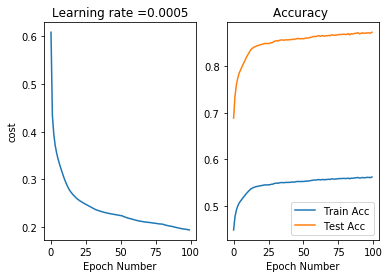

In [27]:
n_epochs = 100
batch_size = 100
m = len(X_train_one)

cost_list =[]
train_acc_list=[]
test_acc_list=[]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        epoch_cost = 0
        start_tm = time.time()
        
        for iteration in range(m // batch_size):
            X_batch = X_train_one[iteration*batch_size:(iteration+1)*batch_size]
            y_batch = y_train_one[iteration*batch_size:(iteration+1)*batch_size]
            _, batch_cost = sess.run([optimizer, cost], feed_dict={X: X_batch, y: y_batch})
            epoch_cost += batch_cost / batch_size
        
        epoch_train_acc = accuracy.eval({X: X_train_one, y: y_train_one})
        epoch_test_acc = accuracy.eval({X: X_test_one, y: y_test_one})
        
        cost_list.append(epoch_cost)
        train_acc_list.append(epoch_train_acc)
        test_acc_list.append(epoch_test_acc)
        
        end_tm = time.time()
        
        if epoch%5 == 0 :
            print ('Epoch %i: Time - %0.2f s Cost - %0.4f Train Acc - %0.2f Test Acc - %0.2f' 
                   % (epoch, (end_tm-start_tm), epoch_cost, 100*epoch_train_acc, 100*epoch_test_acc) )
        
    out_tmp = logits.eval({X: X_test_one[:3], y: y_test_one[:3]})
    
    
fig, ax = plt.subplots(ncols=2)
ax[0].plot(np.squeeze(cost_list))
ax[0].set_ylabel('cost')
ax[0].set_xlabel('Epoch Number')
ax[0].set_title("Learning rate =" + str(L_RATE))

ax[1].plot(train_acc_list, label="Train Acc")
ax[1].plot(test_acc_list, label="Test Acc")
ax[1].set_xlabel('Epoch Number')
ax[1].set_title("Accuracy ")
ax[1].legend()

plt.show()

# Model valid test 

Input X_test array

In [28]:
np.argmax(X_test_one[:3], axis=-1)

array([[[0, 0, 0, 0, 2, 3, 4, 0, 6],
        [6, 0, 7, 1, 0, 0, 0, 0, 3],
        [0, 9, 2, 0, 0, 0, 8, 0, 5],
        [0, 0, 8, 0, 0, 5, 0, 0, 9],
        [7, 0, 9, 0, 0, 6, 1, 0, 0],
        [0, 2, 0, 3, 8, 0, 0, 4, 0],
        [0, 8, 4, 0, 0, 1, 0, 0, 2],
        [1, 5, 0, 0, 7, 0, 0, 3, 0],
        [0, 0, 0, 6, 0, 0, 0, 8, 0]],

       [[6, 0, 0, 0, 9, 4, 7, 0, 0],
        [0, 0, 0, 5, 0, 8, 0, 0, 0],
        [0, 7, 9, 1, 2, 0, 0, 0, 5],
        [0, 0, 8, 0, 3, 0, 0, 0, 4],
        [4, 0, 5, 0, 0, 0, 0, 9, 0],
        [0, 6, 0, 0, 0, 7, 1, 8, 2],
        [0, 0, 0, 0, 4, 3, 0, 2, 0],
        [2, 0, 6, 7, 0, 0, 8, 0, 0],
        [3, 4, 1, 9, 0, 0, 0, 7, 0]],

       [[0, 0, 0, 0, 3, 0, 6, 0, 8],
        [3, 0, 5, 8, 7, 0, 9, 0, 0],
        [0, 0, 4, 9, 6, 0, 1, 0, 0],
        [2, 0, 8, 5, 0, 7, 0, 0, 0],
        [0, 7, 0, 0, 0, 0, 2, 0, 5],
        [4, 0, 9, 0, 8, 0, 0, 0, 3],
        [9, 0, 0, 0, 0, 6, 0, 4, 0],
        [0, 0, 0, 1, 0, 3, 8, 7, 0],
        [0, 1, 6, 4, 0, 0, 0, 9, 0

Predicted Logits array

In [29]:
np.argmax(out_tmp, axis=-1)

array([[[8, 1, 5, 8, 2, 3, 4, 9, 6],
        [6, 4, 7, 1, 5, 8, 2, 9, 3],
        [3, 9, 2, 4, 6, 7, 8, 1, 5],
        [4, 6, 8, 2, 1, 5, 3, 6, 9],
        [7, 3, 9, 2, 4, 6, 1, 2, 8],
        [5, 2, 1, 3, 8, 9, 5, 4, 7],
        [9, 8, 4, 5, 3, 1, 7, 6, 2],
        [1, 5, 6, 8, 7, 8, 9, 3, 4],
        [9, 7, 3, 6, 5, 2, 5, 8, 1]],

       [[6, 5, 2, 3, 9, 4, 7, 1, 8],
        [1, 3, 4, 5, 7, 8, 9, 1, 9],
        [8, 7, 9, 1, 2, 6, 4, 4, 5],
        [1, 1, 8, 2, 3, 9, 5, 5, 4],
        [4, 2, 5, 8, 8, 1, 3, 9, 7],
        [9, 6, 3, 4, 5, 7, 1, 8, 2],
        [8, 8, 7, 6, 4, 3, 5, 2, 9],
        [2, 9, 6, 7, 1, 1, 8, 4, 3],
        [3, 4, 1, 9, 8, 2, 5, 7, 6]],

       [[1, 9, 1, 2, 3, 4, 6, 5, 8],
        [3, 6, 5, 8, 7, 1, 9, 2, 4],
        [8, 2, 4, 9, 6, 5, 1, 3, 7],
        [2, 3, 8, 5, 1, 7, 4, 1, 9],
        [1, 7, 3, 6, 1, 9, 2, 8, 5],
        [4, 5, 9, 2, 8, 1, 7, 6, 3],
        [9, 8, 3, 7, 2, 6, 5, 4, 1],
        [5, 4, 2, 1, 9, 3, 8, 7, 6],
        [7, 1, 6, 4, 2, 8, 5, 9, 2

Target Array

In [30]:
np.argmax(y_test_one[:3], axis=-1)

array([[[8, 1, 5, 9, 2, 3, 4, 7, 6],
        [6, 4, 7, 1, 5, 8, 2, 9, 3],
        [3, 9, 2, 4, 6, 7, 8, 1, 5],
        [4, 6, 8, 7, 1, 5, 3, 2, 9],
        [7, 3, 9, 2, 4, 6, 1, 5, 8],
        [5, 2, 1, 3, 8, 9, 6, 4, 7],
        [9, 8, 4, 5, 3, 1, 7, 6, 2],
        [1, 5, 6, 8, 7, 2, 9, 3, 4],
        [2, 7, 3, 6, 9, 4, 5, 8, 1]],

       [[6, 5, 2, 3, 9, 4, 7, 1, 8],
        [1, 3, 4, 5, 7, 8, 2, 6, 9],
        [8, 7, 9, 1, 2, 6, 4, 3, 5],
        [7, 1, 8, 2, 3, 9, 6, 5, 4],
        [4, 2, 5, 8, 6, 1, 3, 9, 7],
        [9, 6, 3, 4, 5, 7, 1, 8, 2],
        [5, 8, 7, 6, 4, 3, 9, 2, 1],
        [2, 9, 6, 7, 1, 5, 8, 4, 3],
        [3, 4, 1, 9, 8, 2, 5, 7, 6]],

       [[1, 9, 7, 2, 3, 4, 6, 5, 8],
        [3, 6, 5, 8, 7, 1, 9, 2, 4],
        [8, 2, 4, 9, 6, 5, 1, 3, 7],
        [2, 3, 8, 5, 1, 7, 4, 6, 9],
        [6, 7, 1, 3, 4, 9, 2, 8, 5],
        [4, 5, 9, 6, 8, 2, 7, 1, 3],
        [9, 8, 3, 7, 2, 6, 5, 4, 1],
        [5, 4, 2, 1, 9, 3, 8, 7, 6],
        [7, 1, 6, 4, 5, 8, 3, 9, 2